In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True

import torch
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def eval_loss(loader, device, net, criterion):
    images, labels = next(iter(loader))
    inputs = images.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    return loss

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            train_acc += (predicted == labels).sum().item()
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.max(outputs, 1)[1]
            val_acc += (predicted == labels).sum().item()
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print(f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

def evaluate_history(history_finetuning, history_transfer_learning):
    print(f'ファインチューニング初期状態: 損失: {history_finetuning[0,3]:.5f} 精度: {history_finetuning[0,4]:.5f}')
    print(f'ファインチューニング最終状態: 損失: {history_finetuning[-1,3]:.5f} 精度: {history_finetuning[-1,4]:.5f}' )

    print(f'転移学習初期状態: 損失: {history_transfer_learning[0,3]:.5f} 精度: {history_transfer_learning[0,4]:.5f}')
    print(f'転移学習最終状態: 損失: {history_transfer_learning[-1,3]:.5f} 精度: {history_transfer_learning[-1,4]:.5f}' )

    num_epochs = len(history_finetuning)

    if num_epochs < 10:
        unit = 1
    else:
        unit = num_epochs / 10
    plt.figure(figsize=(9,8))
    plt.plot(history_finetuning[:,0], history_finetuning[:,1], 'b', label='ファインチューニング訓練')
    plt.plot(history_finetuning[:,0], history_finetuning[:,3], 'k', label='ファインチューニング検証')
    plt.plot(history_transfer_learning[:,0], history_transfer_learning[:,1], 'r', label='転移学習訓練')
    plt.plot(history_transfer_learning[:,0], history_transfer_learning[:,3], 'g', label='転移学習検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(9,8))
    plt.plot(history_finetuning[:,0], history_finetuning[:,2], 'b', label='ファインチューニング訓練')
    plt.plot(history_finetuning[:,0], history_finetuning[:,4], 'k', label='ファインチューニング検証')
    plt.plot(history_transfer_learning[:,0], history_transfer_learning[:,2], 'r', label='転移学習訓練')
    plt.plot(history_transfer_learning[:,0], history_transfer_learning[:,4], 'g', label='転移学習検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

def show_images_labels(loader, classes, net, device):
    images, labels = next(iter(loader))
    n_size = min(len(images), 50)
    
    if net is not None:
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
    plt.figure(figsize=(20, 15))

    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        if net is not None:
            predicted_name = classes[predicted[i]]
            if label_name == predicted_name:
                c = 'k'
            else:
                c = 'r'
            ax.set_title(label_name[:4] + ':' + predicted_name[:4], c=c, fontsize=20)
        else:
            ax.set_title(label_name, fontsize=20)
            
        image_np = images[i].numpy().copy()
        img = np.transpose(image_np, (1, 2, 0))
        img = (img + 1)/2
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

cuda:0


In [2]:
import os
import shutil
from glob import glob
import random

data_dir = 'data/celeb5'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

id_file_path = './celebA_identity_5.txt'
with open(id_file_path) as f:
    lines = f.readlines()

mapobj = map(lambda x: x.split(), lines)
dic = dict(mapobj)
ids = sorted(list(set(dic.values())))

for id in ids:
    os.makedirs(os.path.join(train_dir, id), exist_ok=True)
    os.makedirs(os.path.join(test_dir, id), exist_ok=True)

shutil.unpack_archive('img_align_celeba_5.zip')
files = glob('img_align_celeba/*.jpg')
random.seed(0)
random.shuffle(files)
train_size = len(files) * 3 // 4

for file in files[:train_size]:
    id_dir = os.path.join(train_dir, dic[os.path.basename(file)])
    shutil.move(file, id_dir)
    
for file in files[train_size:]:
    id_dir = os.path.join(test_dir, dic[os.path.basename(file)])
    shutil.move(file, id_dir)

shutil.rmtree("img_align_celeba")

<class 'PIL.Image.Image'>
(178, 218)


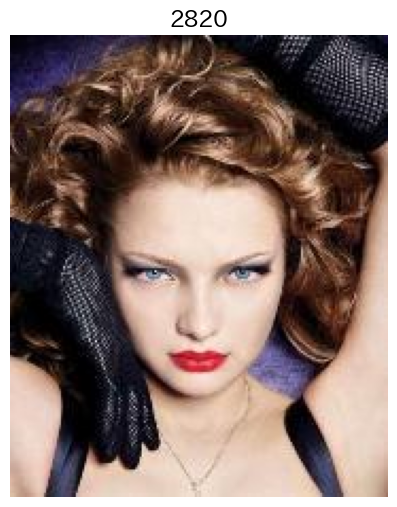

In [3]:
import torchvision.datasets as datasets

dataset = datasets.ImageFolder(root=data_dir + '/train')
classes = dataset.classes
image, label = dataset[0]
print(type(image))
print(image.size)
plt.imshow(image)
plt.title(classes[label])
plt.axis('off')
plt.show()

In [4]:
import torchvision.transforms as transforms

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 125件
検証データ: 42件


In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [6]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchinfo import summary

net = models.densenet201(pretrained = True)
print(net)
summary(net, input_size=(1, 3, 224, 224))

torch_seed(36)

in_features = net.classifier.in_features
net.classifier = nn.Linear(in_features, len(classes))
net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)
history_finetuning = np.zeros((0, 5))
num_epochs = 10
history_finetuning = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history_finetuning)
torch.save(net.state_dict(), 'densenet201_finetuning.pth')

C:\Users\qqnq7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\qqnq7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.39104 acc: 0.35200 val_loss: 0.01984, val_acc: 0.78571


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.20332 acc: 0.74400 val_loss: 0.01341, val_acc: 0.78571


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.18976 acc: 0.73600 val_loss: 0.00708, val_acc: 0.90476


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.08191 acc: 0.89600 val_loss: 0.00510, val_acc: 0.92857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.09163 acc: 0.90400 val_loss: 0.00620, val_acc: 0.88095


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.10883 acc: 0.89600 val_loss: 0.00530, val_acc: 0.92857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.07214 acc: 0.89600 val_loss: 0.00551, val_acc: 0.92857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.08615 acc: 0.89600 val_loss: 0.00712, val_acc: 0.90476


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.04952 acc: 0.92000 val_loss: 0.00464, val_acc: 0.92857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.05877 acc: 0.89600 val_loss: 0.00454, val_acc: 0.90476


densenet201のファインチューニング結果


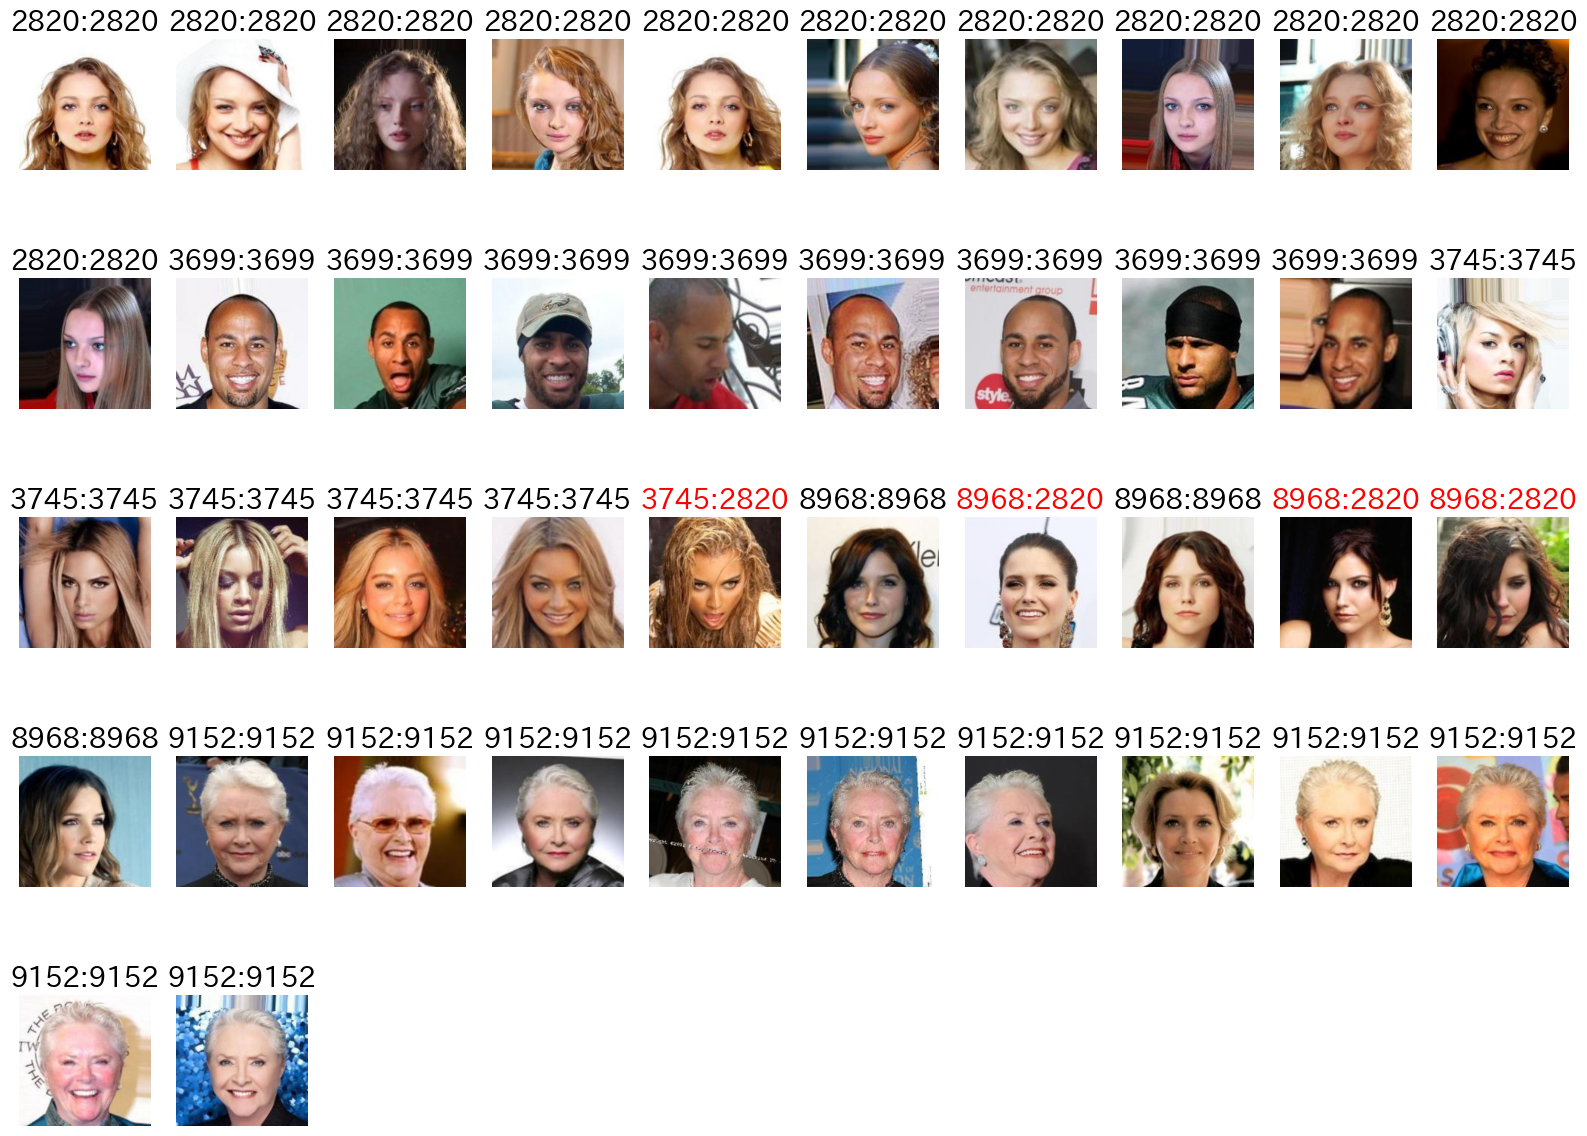

In [7]:
print("densenet201のファインチューニング結果")
show_images_labels(test_loader, classes, net, device)

In [8]:
net = models.densenet201(pretrained = True)
print(net)
summary(net, input_size=(1, 3, 224, 224))

torch_seed(36)

for param in net.parameters():
    param.requires_grad = False

in_features = net.classifier.in_features
net.classifier = nn.Linear(in_features, len(classes))
net = net.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.classifier.parameters(),lr=lr,momentum=0.9)
history_transfer_learning = np.zeros((0, 5))
num_epochs = 10
history_transfer_learning = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history_transfer_learning)
torch.save(net.state_dict(), 'densenet201_transfer_learning.pth')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.41940 acc: 0.29600 val_loss: 0.02972, val_acc: 0.54762


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.29325 acc: 0.55200 val_loss: 0.02400, val_acc: 0.57143


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.29706 acc: 0.52000 val_loss: 0.01811, val_acc: 0.76190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.20981 acc: 0.72000 val_loss: 0.01331, val_acc: 0.83333


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.19314 acc: 0.75200 val_loss: 0.01156, val_acc: 0.90476


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.19304 acc: 0.72800 val_loss: 0.01138, val_acc: 0.80952


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.17979 acc: 0.69600 val_loss: 0.01268, val_acc: 0.78571


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.16814 acc: 0.80000 val_loss: 0.01019, val_acc: 0.88095


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.14841 acc: 0.78400 val_loss: 0.00860, val_acc: 0.85714


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.13501 acc: 0.86400 val_loss: 0.00868, val_acc: 0.85714


densenet201の転移学習結果


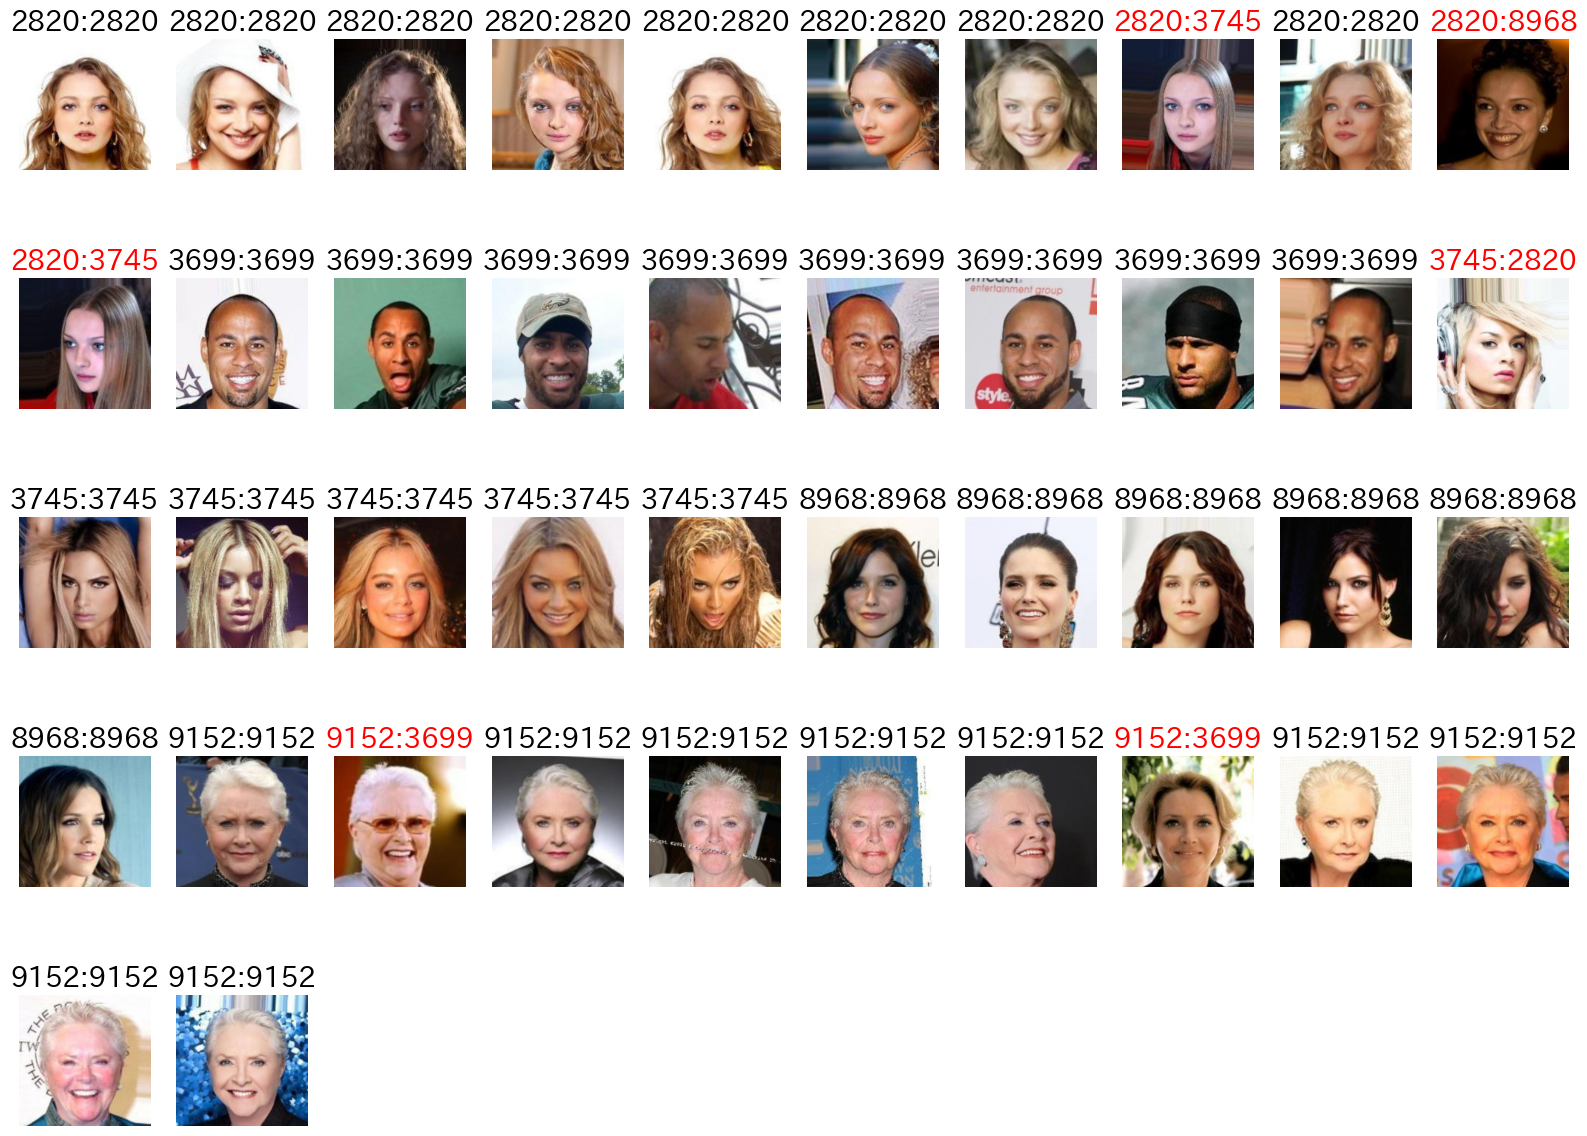

In [9]:
print("densenet201の転移学習結果")
show_images_labels(test_loader, classes, net, device)

densenet201の学習履歴の比較
ファインチューニング初期状態: 損失: 0.01984 精度: 0.78571
ファインチューニング最終状態: 損失: 0.00454 精度: 0.90476
転移学習初期状態: 損失: 0.02972 精度: 0.54762
転移学習最終状態: 損失: 0.00868 精度: 0.85714


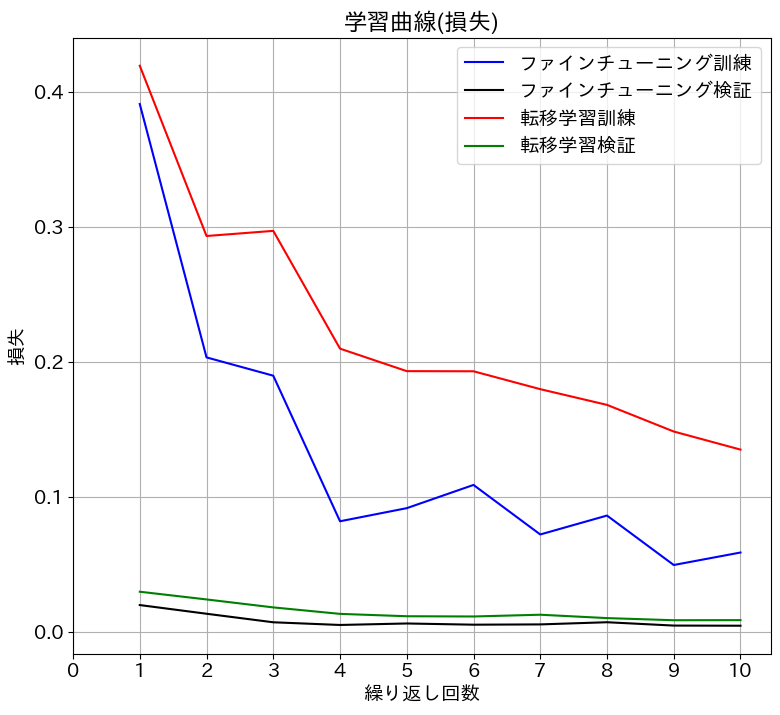

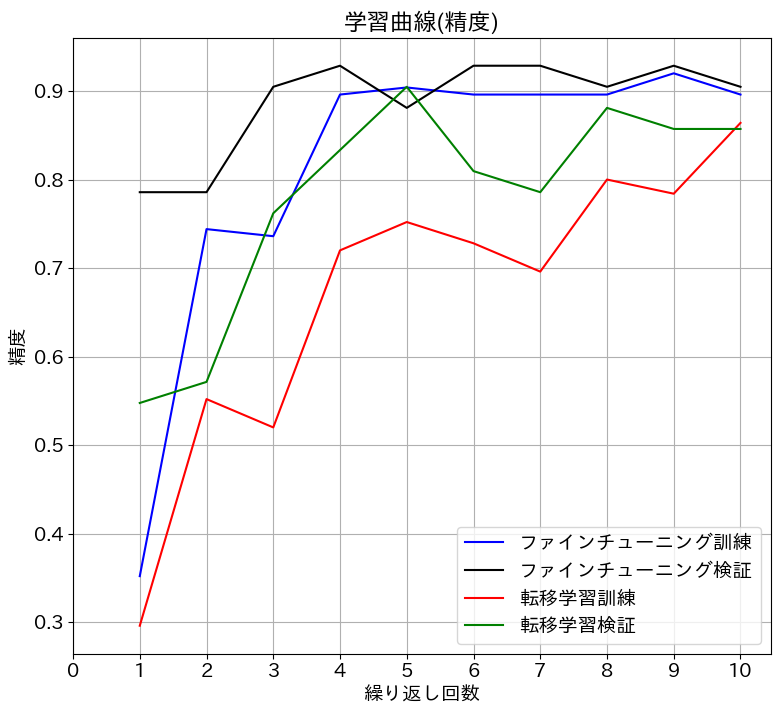

In [10]:
print("densenet201の学習履歴の比較")
evaluate_history(history_finetuning, history_transfer_learning)

In [11]:
net = models.vgg19_bn(pretrained=True)
print(net)
summary(net, input_size=(1, 3, 224, 224))

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, len(classes))

net = net.to(device)

torch_seed(36)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

summary(net, input_size=(1, 3, 224, 224))

history_finetuning = np.zeros((0, 5))
num_epochs = 10
history_finetuning = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history_finetuning)
torch.save(net.state_dict(), 'vgg19_bn_finetuning.pth')

C:\Users\qqnq7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.38203 acc: 0.35200 val_loss: 0.01899, val_acc: 0.76190


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.17847 acc: 0.77600 val_loss: 0.00908, val_acc: 0.85714


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.08775 acc: 0.88000 val_loss: 0.01016, val_acc: 0.90476


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.07864 acc: 0.92000 val_loss: 0.00868, val_acc: 0.85714


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.06040 acc: 0.94400 val_loss: 0.01907, val_acc: 0.85714


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.09303 acc: 0.86400 val_loss: 0.00924, val_acc: 0.88095


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.02829 acc: 0.97600 val_loss: 0.00490, val_acc: 0.90476


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.01104 acc: 0.99200 val_loss: 0.00393, val_acc: 0.92857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.01103 acc: 1.00000 val_loss: 0.00783, val_acc: 0.92857


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.02261 acc: 0.96800 val_loss: 0.00600, val_acc: 0.95238


vgg19_bnのファインチューニング結果


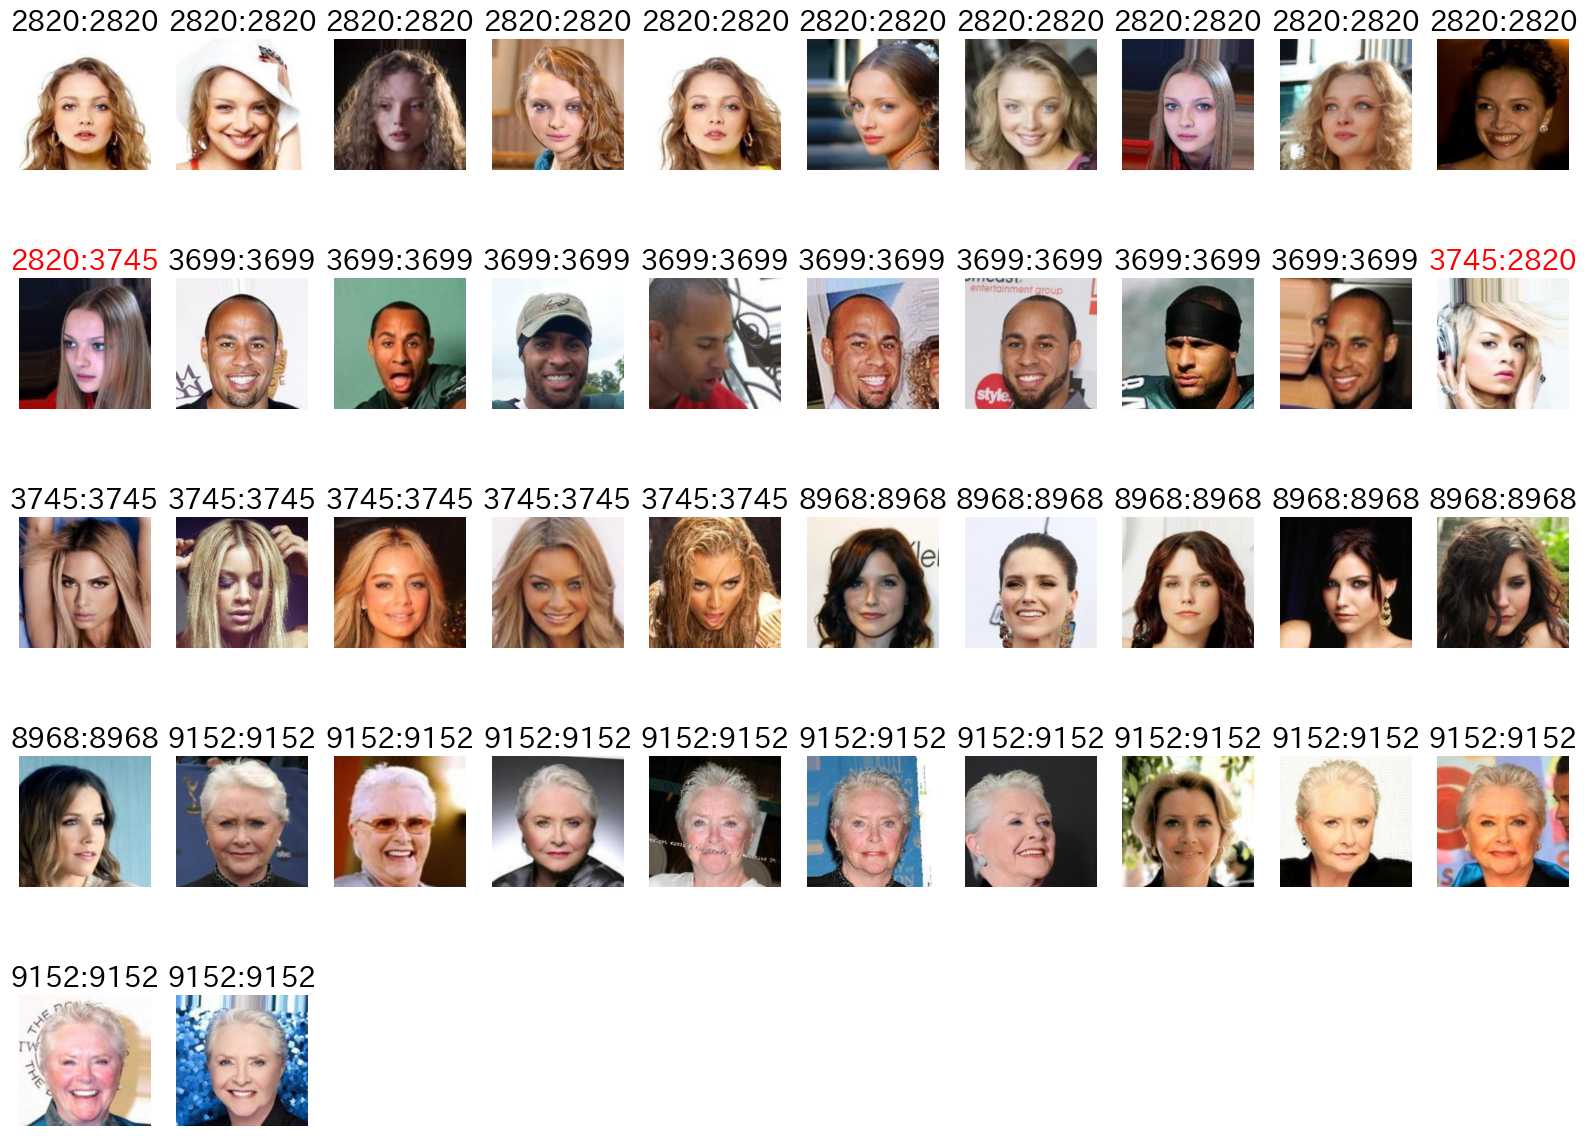

In [12]:
print("vgg19_bnのファインチューニング結果")
show_images_labels(test_loader, classes, net, device)

In [13]:
net = models.vgg19_bn(pretrained=True)
print(net)
summary(net, input_size=(1, 3, 224, 224))

for param in net.parameters():
    param.requires_grad = False

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, len(classes))

net = net.to(device)

torch_seed(36)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.classifier[6].parameters(), lr=0.001, momentum=0.9)

summary(net, input_size=(1, 3, 224, 224))

history_transfer_learning = np.zeros((0, 5))
num_epochs = 10
history_transfer_learning = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history_transfer_learning)
torch.save(net.state_dict(), 'vgg19_bn_transfer_learning.pth')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.39519 acc: 0.36800 val_loss: 0.02097, val_acc: 0.69048


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.24363 acc: 0.64000 val_loss: 0.01337, val_acc: 0.80952


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.18830 acc: 0.71200 val_loss: 0.01090, val_acc: 0.83333


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.19468 acc: 0.72800 val_loss: 0.01161, val_acc: 0.80952


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.14918 acc: 0.82400 val_loss: 0.01304, val_acc: 0.85714


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.18485 acc: 0.79200 val_loss: 0.01088, val_acc: 0.83333


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.16995 acc: 0.76000 val_loss: 0.00750, val_acc: 0.85714


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.12184 acc: 0.84800 val_loss: 0.00727, val_acc: 0.90476


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.15306 acc: 0.82400 val_loss: 0.00728, val_acc: 0.90476


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.13563 acc: 0.79200 val_loss: 0.00816, val_acc: 0.88095


vgg19_bnの転移学習結果


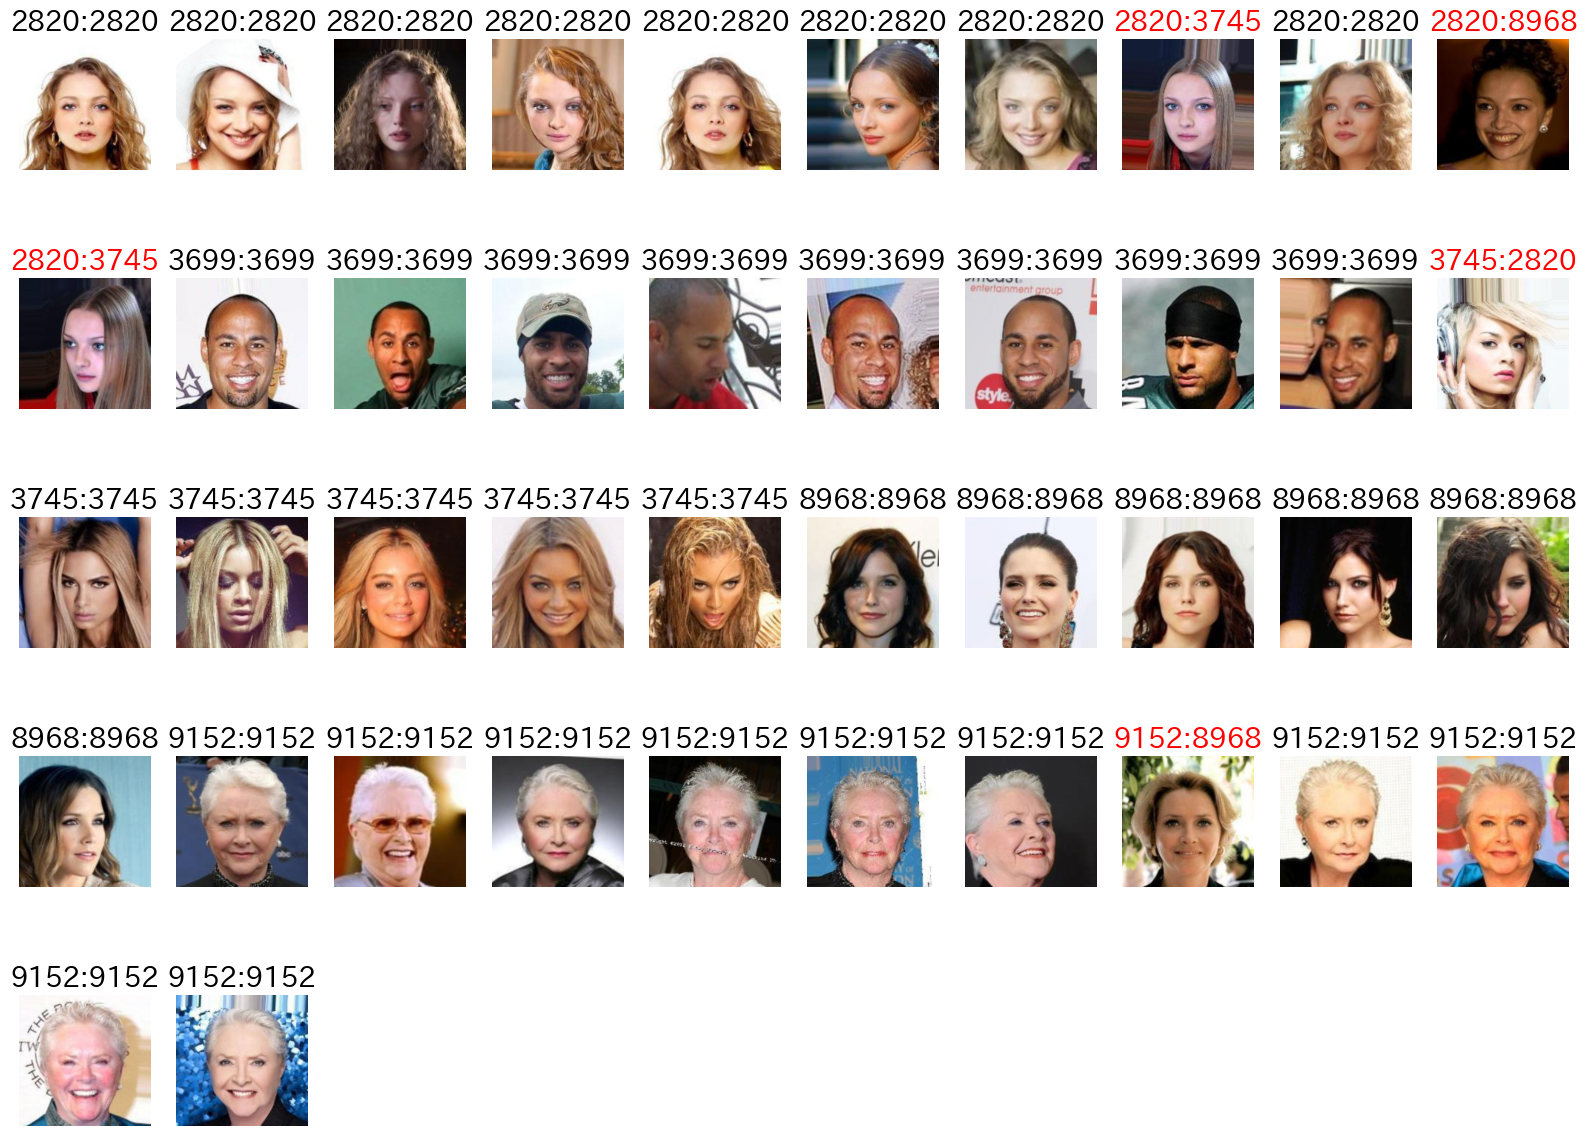

In [14]:
print("vgg19_bnの転移学習結果")
show_images_labels(test_loader, classes, net, device)

vgg19_bnの学習履歴の比較
ファインチューニング初期状態: 損失: 0.01899 精度: 0.76190
ファインチューニング最終状態: 損失: 0.00600 精度: 0.95238
転移学習初期状態: 損失: 0.02097 精度: 0.69048
転移学習最終状態: 損失: 0.00816 精度: 0.88095


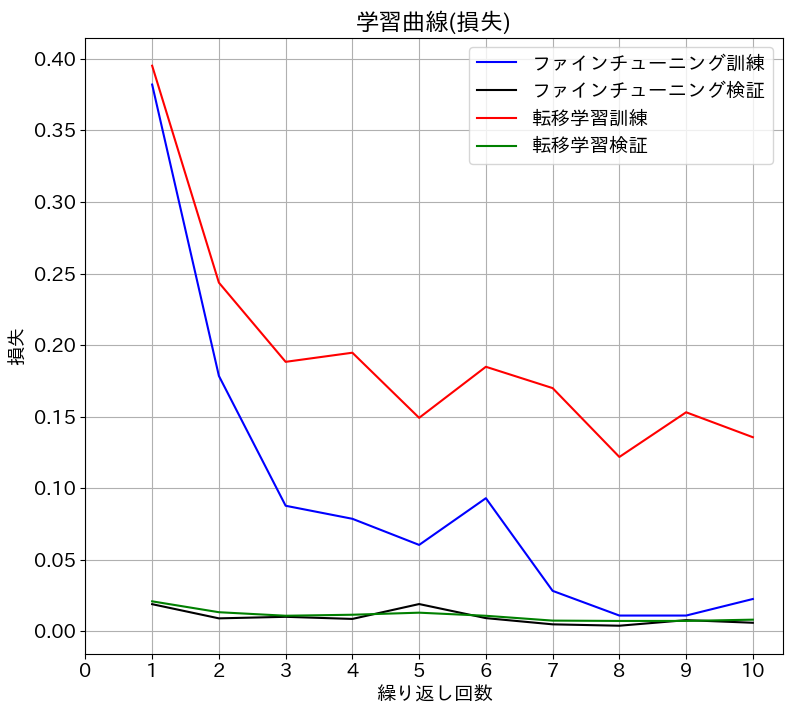

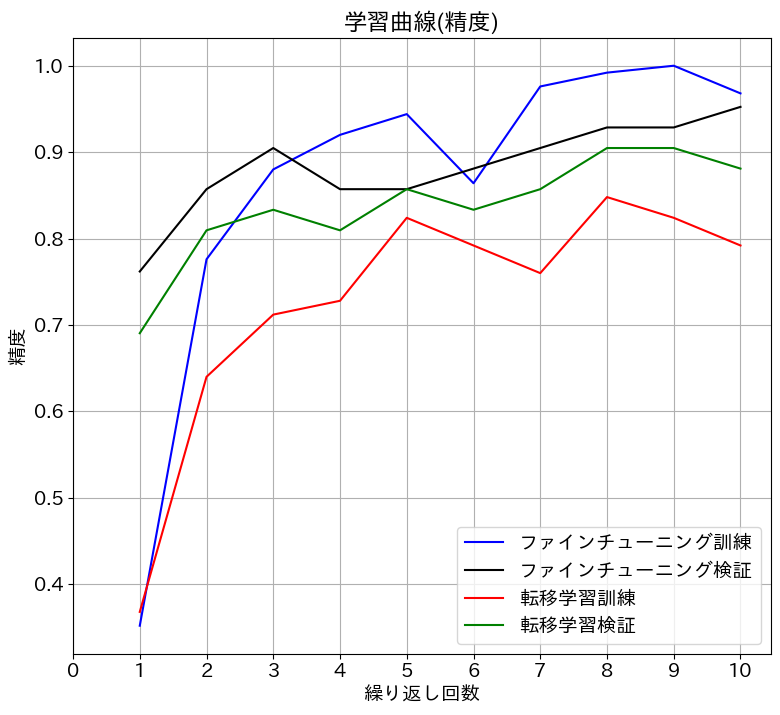

In [15]:
print("vgg19_bnの学習履歴の比較")
evaluate_history(history_finetuning, history_transfer_learning)